Rohith Suresh
UB# 50314092

The Gym Environments used here are 'CartPolev0' and 'CartPolev1'. 'CartPolev0' has a maximum score of 200 and has a threshold of 195 to be considered solved. 'CartPolev1' has a max score of 500 and a threshold of 475 to be considered solved. 'CartPolev0' has been solved in both DQN  and Double DQN.

In [1]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from keras.models     import Sequential
from keras.layers     import Input, Dense
from keras.optimizers import Adam

from IPython.display import clear_output
import random
import time
from matplotlib import pylab
import matplotlib.pyplot as plt 
import os.path

Using TensorFlow backend.


## Hyperparameters common for both the Models and Parts##

These Hyperparameters play a very important role in training the model. The learning rate qill decide how fast or slow the model will reach the global minimum. Too high a Learning Rate may also casue over-shooting. 

Discount Value determinis how much reward the agent is going to get.

Exp_rate is the percentage of Exploration vs Exploitation. Here, 1 means 100% and the Deacy value determines the amount the Expt_rate will decrease per spisode to balance Exploration vs Exploitation. Min_Decay determines the minimum exploration percentage for the agent. Here, the minimum Exploration is 1% no matter what the decay.

The Batch Size is the number for steps to be trained at a time.

Episodes is the number of times the model will execute to be trained.



In [2]:
LERNING_RATE = 0.001
DISCOUNT = 0.95
EXP_RATE = 1.0
DECAY = 0.995
MIN_DECAY = 0.01
BATCH_SIZE = 64
EPISODES = 5000

## Model 1 Part 2 and 3

Change DDQN to True to use Double DQN or comment this part to use DQN on Model 2

In [0]:
################################### THIS DDQN ########################################


# FILE = 'CartPolev0Double3.h5'
# ENV = 'CartPole-v0'
# DDQN = False
# ENV_MAX_AVG = 195

In [3]:
################################### THIS DQN ########################################


FILE = 'CartPolev03---.h5'
ENV = 'CartPole-v0'
DDQN = False
ENV_MAX_AVG = 195

Uncomment this on use DQN on Model 2


In [11]:
# FILE = 'CartPolev1_1.h5'
# ENV = 'CartPole-v1'
# ENV_MAX_AVG = 475
# DDQN = False

## Basic Deep Q-Network (Part 1.1)

This Class contains the Deep Learning Neural Network. The Neural Network has 1 hidden layer with 512 nodes. This is pretty shallow network but it works for the given model. The activation functions used are Relu and Linear for the output layer. The loss function used here is Mean Square Error. 
There two neural networks used here, one for the q_value and another for the target q_value. 

The act function chosses the action to do for that step based Exploration and Exploitation. For exploration, the action is choosen randomly and for exploiation, the action is predicted by the neural network. 

The get_q_value function, returns the q_value(Q_max = reward + gamma * Q_max). This is the party that varies for DQN and Double DQN. Double DQN is supposed to help the Neural Network learn faster. 

The Replay function is were the learning happens. The data stored in to memory is removed in batches and the q_value(s) is/are calulated before the model is trained. Here the Q_value and Max(Q_value), both are predicted by tyhe neural networks. This the main part where the nertorks are trained.


In [6]:
class DQN_agent():
  def __init__(self, s_size, a_size):
    self.s_size = s_size
    self.a_size = a_size
    self.lr = LERNING_RATE
    self.g = DISCOUNT
    self.exp = EXP_RATE
    self.exp_d = DECAY
    self.exp_min = MIN_DECAY
    self.storage = deque(maxlen = 20000)
    self.neural_net = self.neural()
    self.neural_net.compile(loss='mse', optimizer=Adam(lr=self.lr), metrics = ['accuracy'])
    self.target_nn = self.neural()
    self.target_nn.compile(loss='mse', optimizer=Adam(lr=self.lr), metrics = ['accuracy'])
    # self.target_nn = self.weight_update()
    self.target_nn.set_weights(self.neural_net.get_weights())
    self.double = DDQN
    self.counter = 0
  
  def neural(self):
    model = Sequential()
    model.add(Dense(10, input_dim=self.s_size, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(self.a_size, activation='linear'))
#     model.summary()

    if os.path.isfile(FILE):
      print("loaded model")
      model.load_weights(FILE)
      self.exp = self.exp_min

    return model
    


  def action(self,state):
    rand_variable = np.random.rand()
    if rand_variable <= self.exp:
      return random.randrange(self.a_size)
    
    v = self.neural_net.predict(state)
    return np.argmax(v[0])

  def store(self, s, a, r, _s, d):
    self.storage.append((s, a, r, _s, d))


  def get_q_value(self, next_state, reward):
    if self.double:
      action = np.argmax(self.neural_net.predict(next_state)[0])
      q_value = self.target_nn.predict(next_state)[0][action]
    else:
      q_value = np.amax(self.target_nn.predict(next_state)[0])
    
    q_value *= self.g
    q_value += reward
    return q_value

  def exp_replay(self, batch_s = BATCH_SIZE):
    state_batch, target_batch = [], []
    if len(self.storage) < batch_s:
      return
    sample_batch = random.sample(self.storage, batch_s)
    for state, action, reward, next_state, done in sample_batch:
      target_f = self.neural_net.predict(state)
      target = self.get_q_value(next_state, reward)
      if not done:
        target_f[0][action] = target
      elif done:
        target_f[0][action] = reward
      
      state_batch.append(state[0])
      target_batch.append(target_f[0])
    self.neural_net.fit(np.array(state_batch), np.array(target_batch), batch_size = BATCH_SIZE, epochs=1, verbose=0)
    
    if self.exp > self.exp_min:
      self.exp *= self.exp_d

    if(self.counter % 10 == 0):
      self.target_nn.set_weights(self.neural_net.get_weights())

    self.counter += 1


# Implementing GYM environments with DQN/DDQN (Part 1.2)

The environment, states, actions are provided bt the Open AI Gym environment. The environment also provides Step function that givesthe information of the agent when the given action is taken in the environment. There are 2 loops, one for the episode and the other for the steps in that episode. The moving average for the past 100 episodes is calculated with the past 100 scores. This will determine if the agent is being trained.

In [ ]:
ep = EPISODES 
env = gym.make(ENV)
obs_size = env.observation_space.shape[0]
action_size = env.action_space.n
player = DQN_agent(obs_size, action_size)
score = 0
ep_avg = []
sc_for_graph = []
score_h = deque(maxlen = 100)
count = 0

try:
  for e in range(1, ep):
    S = np.reshape(env.reset(), [1, obs_size])
    i = 1000
    score = 0
    for j in range(i):
      A = player.action(S)
      _S, R, done, info = env.step(A)
      _S = np.reshape(_S, [1, obs_size])
      player.store(S, A, R, _S, done)
      S = _S
      score += R
      if done:
        break
    sc_for_graph.append(score)
    score_h.append(score)
    if(e > 99):
      ep_avg.append(np.mean(score_h))
    player.exp_replay()
    if(np.mean(score_h) >= ENV_MAX_AVG):
      print("solved at episode: ", e," with avg: ", score_h)
      player.neural_net.save(FILE,overwrite = True)
      count += 1
    
    if(count == 2):
        player.neural_net.save(FILE,overwrite = True)
        break

    print("Ep {}/{}# Score:{}".format(e, ep, score))
    if(e > 99):
        print("moving avg is:  ", np.mean(score_h))
        plt.figure(2)
        plt.clf()
        plt.plot(sc_for_graph)
        plt.plot(ep_avg)
        plt.show()
        time.sleep(0.3)
        clear_output()
finally:
  player.neural_net.save(FILE,overwrite = True)



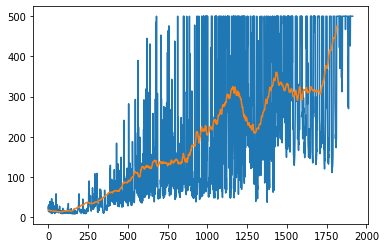

In [14]:
#   player.neural_net.save("zero.h5",overwrite = True)
fig = plt.figure(2)
plt.clf()
plt.plot(sc_for_graph)
plt.plot(ep_avg)
plt.show()
fig.savefig('plotDQNv1.png')


## Result

The Model we are using to compare DQN and Double DQN is Cartpole-v0. When we are using DDQN, we can see that the agent is able to solve the environment faster then when using DQN. And also when we use DDQN, we  can see that the predictions are more stable. 
When we use DQN, there are many times that he moving average falls from a high value. But, in a DDQN model the average value raises constantly. This proves the the predictions in DDQN is more accurate.


## Test

Use this block to run the trained model. The trained neural net can be used by loading the saved weights in the folder can be used by uncommenting the block above

In [17]:
def test_neural(s_size, a_size):
    model = Sequential()
    model.add(Dense(512, input_dim = s_size, activation='relu'))
#     model.add(Dense(256, activation='relu'))
    model.add(Dense(a_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics = ['accuracy'])
    return model

eval_env = gym.make(ENV)
eval_obs_size = eval_env.observation_space.shape[0]
eval_action_size = eval_env.action_space.n
eS = np.reshape(eval_env.reset(), [1, eval_obs_size])
model_n = test_neural(eval_obs_size, eval_action_size)
model_n.load_weights(FILE)
score = 0
    
i = ENV_MAX    
for j in range(i):
    eval_env.render()
    value = model_n.predict(eS)
    eA = np.argmax(value[0])
    e_S, eR, done, info = eval_env.step(eA)
    e_S = np.reshape(e_S, [1, eval_obs_size])
    eS = e_S
    score += eR
#     if done:
#         break
eval_env.close()        
print("Score: ", score)

Score:  475.0
